In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import paper_utils as pu

In [2]:
df = pu.load_data(drop_dups=True)
df['mid'] = (df['best_bid'] + df['best_ask']) / 2
df = df[df['best_bid'] != 0].reset_index(drop=True)
df.head()

,date,exdate,strike_price,lifeTime,volume,open_interest,best_bid,best_ask,daysToExpiry,mid
0,2000-01-03,2000-03-18,1410000,75,0,1,36.750,38.750,75,37.750
1,2000-01-03,2000-01-22,1505000,19,0,50,55.250,57.250,19,56.250
2,2000-01-03,2000-06-17,1350000,166,290,14570,40.750,42.750,166,41.750
3,2000-01-03,2000-01-22,1500000,19,57,505,51.625,53.625,19,52.625
4,2000-01-03,2000-01-22,1540000,19,0,0,84.875,86.875,19,85.875


In [3]:
df_secid = df[['exdate','strike_price']].drop_duplicates().dropna()
df_secid['secid'] = range(len(df_secid))
df_secid.head()

,exdate,strike_price,secid
0,2000-03-18,1410000,0
1,2000-01-22,1505000,1
2,2000-06-17,1350000,2
3,2000-01-22,1500000,3
4,2000-01-22,1540000,4


In [4]:
df = df.merge(df_secid, how = 'inner', on = ['exdate','strike_price'], validate = 'm:1')
df.head()

,date,exdate,strike_price,lifeTime,volume,open_interest,best_bid,best_ask,daysToExpiry,mid,secid
0,2000-01-03,2000-03-18,1410000,75,0,1,36.750,38.750,75,37.750,0
1,2000-01-04,2000-03-18,1410000,75,532,527,57.125,59.125,74,58.125,0
2,2000-01-05,2000-03-18,1410000,75,1961,1840,55.875,57.875,73,56.875,0
3,2000-01-06,2000-03-18,1410000,75,1280,2606,62.375,64.375,72,63.375,0
4,2000-01-07,2000-03-18,1410000,75,10,2574,31.500,33.500,71,32.500,0


In [5]:
import stock_apis as sa
client = sa.get_tiingo_client()

df_spy = client.get_dataframe('SPY','2000-01-03','2019-12-31').reset_index()[['date','close','adjClose']]
df_spy['date'] = pd.to_datetime(df_spy['date']).dt.tz_localize(None)

df_spy.head()

,date,close,adjClose
0,2000-01-03,145.4375,98.511539
1,2000-01-04,139.7500,94.659133
2,2000-01-05,140.0000,94.828469
3,2000-01-06,137.7500,93.304440
4,2000-01-07,145.7500,98.723210


In [6]:
df = df.merge(df_spy, how = 'left', on = 'date', validate = 'm:1')
df.head()

,date,exdate,strike_price,lifeTime,volume,open_interest,best_bid,best_ask,daysToExpiry,mid,secid,close,adjClose
0,2000-01-03,2000-03-18,1410000,75,0,1,36.750,38.750,75,37.750,0,145.4375,98.511539
1,2000-01-04,2000-03-18,1410000,75,532,527,57.125,59.125,74,58.125,0,139.7500,94.659133
2,2000-01-05,2000-03-18,1410000,75,1961,1840,55.875,57.875,73,56.875,0,140.0000,94.828469
3,2000-01-06,2000-03-18,1410000,75,1280,2606,62.375,64.375,72,63.375,0,137.7500,93.304440
4,2000-01-07,2000-03-18,1410000,75,10,2574,31.500,33.500,71,32.500,0,145.7500,98.723210


In [136]:
trade_freq = 'm' # 'm', 'q', 'h', 'y'

try:
    del df['endOfPeriod']
except:
    pass

df['moneyness'] = 1 - df['strike_price'] / df['close'] / 1e4

if trade_freq == 'm':
    df['periodId'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)
elif trade_freq == 'q':
    df['periodId'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.quarter.astype(str)
elif trade_freq == 'h':
    df['periodId'] = df['date'].dt.year.astype(str) + '-' + ((df['date'].dt.quarter - 1) // 2 + 1).astype(str)
elif trade_freq == 'y':
    df['periodId'] = df['date'].dt.year.astype(str)
    
df_end_of_period = df.groupby('periodId')['date'].max().reset_index()
df_end_of_period.columns = ['periodId','endOfPeriod']
df = df.merge(df_end_of_period, how = 'left', on = 'periodId', validate = 'm:1')
all_trading_days = sorted(set(df['endOfPeriod']))
df.head()

,date,exdate,strike_price,lifeTime,volume,open_interest,best_bid,best_ask,daysToExpiry,mid,secid,close,adjClose,moneyness,periodId,endOfPeriod
0,2000-01-03,2000-03-18,1410000,75,0,1,36.750,38.750,75,37.750,0,145.4375,98.511539,0.030511,2000-1,2000-01-31
1,2000-01-04,2000-03-18,1410000,75,532,527,57.125,59.125,74,58.125,0,139.7500,94.659133,-0.008945,2000-1,2000-01-31
2,2000-01-05,2000-03-18,1410000,75,1961,1840,55.875,57.875,73,56.875,0,140.0000,94.828469,-0.007143,2000-1,2000-01-31
3,2000-01-06,2000-03-18,1410000,75,1280,2606,62.375,64.375,72,63.375,0,137.7500,93.304440,-0.023593,2000-1,2000-01-31
4,2000-01-07,2000-03-18,1410000,75,10,2574,31.500,33.500,71,32.500,0,145.7500,98.723210,0.032590,2000-1,2000-01-31


In [145]:
v0 = 100
frac_opt = 0.03
min_protect = 0.25
min_duration = 93
trade_spy = True

trading_days = all_trading_days[:]

td = trading_days[0]
idx = df['date'] == td
df_start = df[idx].copy()
idx = df_start['moneyness'] > min_protect
idx&= df_start['daysToExpiry'] > min_duration
# idx&= df_start['volume'] > 0
df_opt_now = df_start[idx].copy().sort_values('mid').iloc[0]
noptions = frac_opt * v0 / df_opt_now['mid']
nspy = trade_spy * (1 - frac_opt) * v0 / df_opt_now['adjClose']

v_lst = [v0]
n_lst = [noptions]
ns_lst = [nspy]
tds = [td]
opts = [df_opt_now]

In [146]:
for td in trading_days[1:]:
    idx = df['date'] == td
    df_now = df[idx].copy()
    idx = df_now['moneyness'] > min_protect
    idx&= df_now['daysToExpiry'] > min_duration
#     idx&= df_now['volume'] > 0
    
    v_new = trade_spy * df_now[idx]['adjClose'].mean() * nspy + \
            (1 - trade_spy) * v_lst[-1] * (1 - frac_opt)
    try:
        v_new+= df_now[idx & \
                       (df_now['secid'] == df_opt_now['secid'])]['mid'].values[0] * noptions
    except:
        pass
    
    v_lst.append(v_new)
    
    df_opt_now = df_now[idx].copy().sort_values('mid').iloc[0]
    noptions = frac_opt * v_new / df_opt_now['mid']
    nspy = trade_spy * (1 - frac_opt) * v_new / df_opt_now['adjClose']
    
    tds.append(td)
    opts.append(df_opt_now)
    n_lst.append(noptions)
    ns_lst.append(nspy)

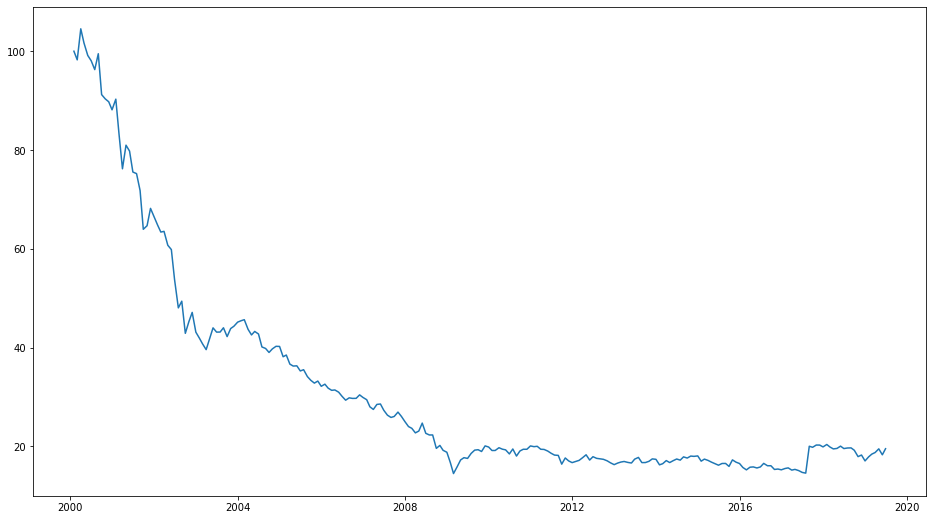

In [147]:
fig, ax = plt.subplots(figsize = (16,9))
plt.plot(tds, v_lst)

In [93]:
df_expire = df.groupby('secid')['daysToExpiry'].min().reset_index()
df_expire.rename({'daysToExpiry':'minDaysToExpiry'}, axis = 1, inplace = True)
df = df.merge(df_expire, how = 'left', on = 'secid', validate = 'm:1')

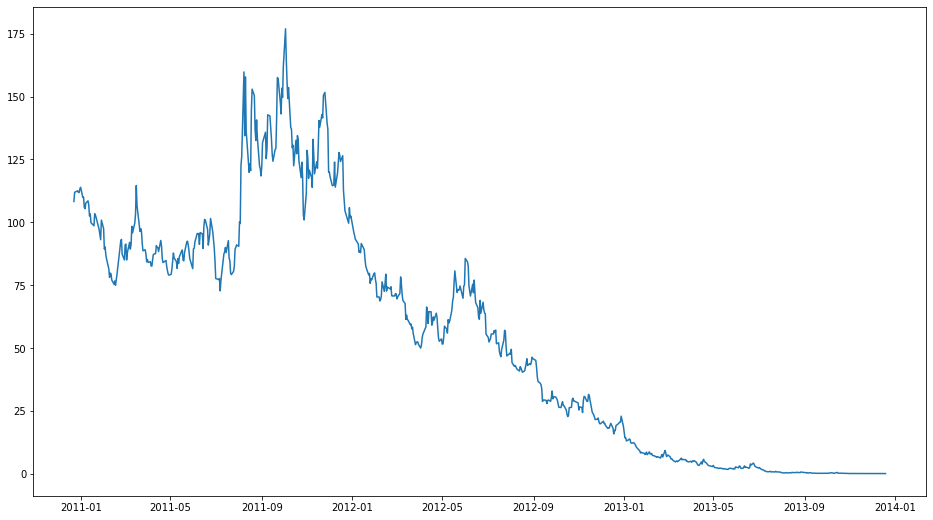

In [99]:
fig, ax = plt.subplots(figsize = (16,9))
df_plt = df[idx][['date','mid']].sort_values('date').reset_index(drop = True)
plt.plot(df_plt['date'], df_plt['mid'])

In [128]:
slct = ['exdate','strike_price','lifeTime','yrMonth','endOfMonth']
calc = ['mid','moneyness','daysToExpiry']
df_monthly = df.groupby(slct)[calc].last().reset_index().sort_values(slct)
df_monthly = df_monthly[df_monthly['exdate'] > df_monthly['endOfMonth']].reset_index(drop=True)